# User based collaborative filtering

In [1]:
## Importing modules

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
## Importing data
reviews = pd.read_csv('IL_review.csv', usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business = pd.read_csv('business.csv', usecols= ['business_id', 'name'])
users = pd.read_csv('IL_users.csv', usecols= ['user_id', 'name'])

## Since users and business dataframe both have the same column names we will update them accordingly
users = users.rename(columns = { 'name': 'Username' })
business = business.rename(columns = { 'name': 'Restaurant name' })

In [3]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars'], dtype='object')

In [4]:
business.head()

,business_id,Restaurant name
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House
1,-LfTBo0oa_uD454ScEW2XA,Merry Ann's Diner
2,R32Yh0XxxanldkIp11fuRg,BoBo's BBQ
3,uJIIgBmcIn-Ye-anrqK0DQ,Dunkin'
4,4Vig7oCo9P-j2OnPUfaXCA,Papa John's Pizza


In [5]:
users.columns

Index(['user_id', 'Username'], dtype='object')

In [6]:
reviews.head()

,review_id,user_id,business_id,stars
0,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0
1,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0
2,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0
3,YIMS3PGxfWN5iFIIcYJHEg,m7rosN4Yh__tXkWP0_myqw,9MnbQg7kfb_WgxoV0hXKSQ,5.0
4,CWjzk0w-OZwzOmCut-6bvQ,iYwDTxhYStsIDHB514ltjA,t_yiQnxUDdPPCN2z4QyezA,5.0


### Since this is a userbased collaborative filtering, we will use stars given by user to make recommendations

In [7]:
# Combine the columns from the given dataframe to consist only of required columns for model
ratings_data = reviews.join(business.set_index('business_id'), on='business_id')
ratings_data = ratings_data.join(users.set_index('user_id'), on = 'user_id')
ratings_data.head()

,review_id,user_id,business_id,stars,Restaurant name,Username
0,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0,Orange & Brew,Helen
1,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0,Dublin O'Neil's,Angela
2,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0,The Bread Company,Charlie
3,YIMS3PGxfWN5iFIIcYJHEg,m7rosN4Yh__tXkWP0_myqw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,Black Dog Smoke & Ale House,Seth
4,CWjzk0w-OZwzOmCut-6bvQ,iYwDTxhYStsIDHB514ltjA,t_yiQnxUDdPPCN2z4QyezA,5.0,Golden Harbor Authentic Chinese Cuisine,Elizabeth


In [8]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(ratings_data[['user_id', 'business_id', 'stars']], reader)

# An antiset is a set of those user and item pairs for which a rating doesn't exist in original dataset
# We will use this data for testing
anti_set = data.build_full_trainset().build_anti_testset()

In [9]:
business = business.drop_duplicates(['business_id' , 'Restaurant name'])
users = users.drop_duplicates(['user_id' , 'Username'])

In [10]:
## Fit the model with 3 splits

kf = KFold(n_splits=3)
algo = KNNBasic()
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_pred = predictions

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4097
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4281
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4034


In [11]:
# Fitting with splits 5
kf = KFold(n_splits=5)
sim_options = {'name':'cosine'}
algo = KNNWithMeans(sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_rmse= rmse
        best_pred = predictions
print(best_rmse)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4267
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4183
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4097
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4276
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4462
1.409735018207292


In [12]:
kf = KFold(n_splits=3)
algo = KNNBaseline(k=3)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse = rmse
        best_algo = algo
        best_pred = predictions

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3746
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3803
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3750


### Changing similarity option and setting the preference to user based filtering

In [13]:
sim_options = { 'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions
    

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4124
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4229
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3973
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4090
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4247


### Analyzing the predictions

In [14]:
pred_df = pd.DataFrame(best_pred).merge(ratings_data , left_on = ['uid', 'iid'], right_on = ['user_id', 'business_id'])
pred_df[['uid', 'iid',  'Username', 'user_id', 'Restaurant name', 'business_id', 'est','stars']]

,uid,iid,Username,user_id,Restaurant name,business_id,est,stars
0,ddduVOhcIjvgy8dQRoykIA,e9shtyZ7-9GYcbPIVV--XQ,Glaucia,ddduVOhcIjvgy8dQRoykIA,Escobar's Restaurant,e9shtyZ7-9GYcbPIVV--XQ,3.595811,1.0
1,qJCuhlCmOuywVHhijygdbg,u8C8pRvaHXg3PgDrsUHJHQ,Erin,qJCuhlCmOuywVHhijygdbg,Papa Del's Pizza,u8C8pRvaHXg3PgDrsUHJHQ,2.597091,3.0
2,7vNSONJuI4XMrdS_-lDnGQ,68HNLNwMfXu1NuL_2E4N7A,Julia,7vNSONJuI4XMrdS_-lDnGQ,Doodles,68HNLNwMfXu1NuL_2E4N7A,4.926154,4.0
3,ww5Qr8OIJZWvkKSoqrXuuw,u8C8pRvaHXg3PgDrsUHJHQ,Reid,ww5Qr8OIJZWvkKSoqrXuuw,Papa Del's Pizza,u8C8pRvaHXg3PgDrsUHJHQ,3.595811,5.0
4,O-9ZXO_tH-aiiuDr1sivwQ,CObgcxFJuEXZZpm4Mw3z1A,Ellen,O-9ZXO_tH-aiiuDr1sivwQ,McDonald's,CObgcxFJuEXZZpm4Mw3z1A,1.000000,1.0
...,...,...,...,...,...,...,...,...
7549,MVk-mbOhXvnYoOHFHmv8UA,IGb6MjNdPRsNVNEplGG3RA,Athena,MVk-mbOhXvnYoOHFHmv8UA,The Blind Pig Brewery,IGb6MjNdPRsNVNEplGG3RA,2.731580,4.0
7550,z6t31TPfBHm9rRNrTGfgVQ,pFvyOYi1O5umrbzGVYSYKg,Kul,z6t31TPfBHm9rRNrTGfgVQ,Edible Arrangements,pFvyOYi1O5umrbzGVYSYKg,3.595811,5.0
7551,S6PayXGBOmXUXRX5AsabAg,th4pZ5LkoIIkb1Vmu_m2DA,Jennifer,S6PayXGBOmXUXRX5AsabAg,Meatheads,th4pZ5LkoIIkb1Vmu_m2DA,3.595811,5.0
7552,Rr8JAEqPttZnnIb2IIUAaQ,8k2l-fbaeQU9lVG4oRgxUw,Timothy,Rr8JAEqPttZnnIb2IIUAaQ,Prairie Fire Restaurant,8k2l-fbaeQU9lVG4oRgxUw,3.850923,4.0


In [15]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(business , left_on = ['iid'], right_on = ['business_id'])
pred_df = pd.DataFrame(pred_df).merge(users , left_on = ['uid'], right_on = ['user_id'])

In [16]:
pred_df[:10]

,uid,iid,r_ui,est,details,business_id,Restaurant name,user_id,Username
0,6X0i-oGUbh5DZdTHzFuKfg,VHsNB3pdGVcRgs6C3jt6Zg,3.599084,2.316172,"{'actual_k': 3, 'was_impossible': False}",VHsNB3pdGVcRgs6C3jt6Zg,Dublin O'Neil's,6X0i-oGUbh5DZdTHzFuKfg,Helen
1,6X0i-oGUbh5DZdTHzFuKfg,Ah4i15g8Ow_zphzcpulTxQ,3.599084,3.997542,"{'actual_k': 3, 'was_impossible': False}",Ah4i15g8Ow_zphzcpulTxQ,The Bread Company,6X0i-oGUbh5DZdTHzFuKfg,Helen
2,6X0i-oGUbh5DZdTHzFuKfg,9MnbQg7kfb_WgxoV0hXKSQ,3.599084,4.256036,"{'actual_k': 3, 'was_impossible': False}",9MnbQg7kfb_WgxoV0hXKSQ,Black Dog Smoke & Ale House,6X0i-oGUbh5DZdTHzFuKfg,Helen
3,6X0i-oGUbh5DZdTHzFuKfg,t_yiQnxUDdPPCN2z4QyezA,3.599084,4.273609,"{'actual_k': 3, 'was_impossible': False}",t_yiQnxUDdPPCN2z4QyezA,Golden Harbor Authentic Chinese Cuisine,6X0i-oGUbh5DZdTHzFuKfg,Helen
4,6X0i-oGUbh5DZdTHzFuKfg,-fiUXzkxRfbHY9TKWwuptw,3.599084,2.916229,"{'actual_k': 3, 'was_impossible': False}",-fiUXzkxRfbHY9TKWwuptw,DESTIHL Restaurant & Brew Works,6X0i-oGUbh5DZdTHzFuKfg,Helen
5,6X0i-oGUbh5DZdTHzFuKfg,NEVA0IYbawceL6kz5v5DAw,3.599084,2.397794,"{'actual_k': 3, 'was_impossible': False}",NEVA0IYbawceL6kz5v5DAw,Kofusion,6X0i-oGUbh5DZdTHzFuKfg,Helen
6,6X0i-oGUbh5DZdTHzFuKfg,RwMlwusAtxZc5a3ZYduulg,3.599084,3.327821,"{'actual_k': 3, 'was_impossible': False}",RwMlwusAtxZc5a3ZYduulg,Penn Station,6X0i-oGUbh5DZdTHzFuKfg,Helen
7,6X0i-oGUbh5DZdTHzFuKfg,ObNQVg_ohRVLex4ppmMC5w,3.599084,4.487973,"{'actual_k': 1, 'was_impossible': False}",ObNQVg_ohRVLex4ppmMC5w,Sonic Drive-In,6X0i-oGUbh5DZdTHzFuKfg,Helen
8,6X0i-oGUbh5DZdTHzFuKfg,-Jhlh8Scjy669NdtCfKSSg,3.599084,2.603740,"{'actual_k': 3, 'was_impossible': False}",-Jhlh8Scjy669NdtCfKSSg,V Picasso,6X0i-oGUbh5DZdTHzFuKfg,Helen
9,6X0i-oGUbh5DZdTHzFuKfg,wpDJUu8Ty_eyQJENUy7fIw,3.599084,3.763933,"{'actual_k': 3, 'was_impossible': False}",wpDJUu8Ty_eyQJENUy7fIw,Smoky's House BBQ,6X0i-oGUbh5DZdTHzFuKfg,Helen


In [17]:
## Recommend a restaurant to the user if the estimated rating is equal to 5

pred_df[(pred_df['est'] == 5)&(pred_df['user_id']=='6X0i-oGUbh5DZdTHzFuKfg')]

,uid,iid,r_ui,est,details,business_id,Restaurant name,user_id,Username
22,6X0i-oGUbh5DZdTHzFuKfg,WU7HnTim3UgqdtpKCavtOw,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",WU7HnTim3UgqdtpKCavtOw,Los Zarapes,6X0i-oGUbh5DZdTHzFuKfg,Helen
41,6X0i-oGUbh5DZdTHzFuKfg,Piw4Xr1wNyL4lgmwLZ2eTg,3.599084,5.0,"{'actual_k': 2, 'was_impossible': False}",Piw4Xr1wNyL4lgmwLZ2eTg,Jet's Pizza,6X0i-oGUbh5DZdTHzFuKfg,Helen
58,6X0i-oGUbh5DZdTHzFuKfg,BQMVcJQV70gUQjwi7-MrSg,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",BQMVcJQV70gUQjwi7-MrSg,Gustoso Authentic Italian Pasta and Pizza,6X0i-oGUbh5DZdTHzFuKfg,Helen
62,6X0i-oGUbh5DZdTHzFuKfg,FZ6nk9Fg27KMgt7oiB0DGA,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",FZ6nk9Fg27KMgt7oiB0DGA,Pies by Inge,6X0i-oGUbh5DZdTHzFuKfg,Helen
64,6X0i-oGUbh5DZdTHzFuKfg,39Sa6I5Bf6hN1KstkpNHbg,3.599084,5.0,"{'actual_k': 2, 'was_impossible': False}",39Sa6I5Bf6hN1KstkpNHbg,"B. Lime, A Green Store",6X0i-oGUbh5DZdTHzFuKfg,Helen
...,...,...,...,...,...,...,...,...,...
811,6X0i-oGUbh5DZdTHzFuKfg,cjdX2cwSmp47ia47V3YySg,3.599084,5.0,"{'actual_k': 2, 'was_impossible': False}",cjdX2cwSmp47ia47V3YySg,Layalina Mediterranean Grill,6X0i-oGUbh5DZdTHzFuKfg,Helen
816,6X0i-oGUbh5DZdTHzFuKfg,D88CTD2UrsSTsrDDuL04_A,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",D88CTD2UrsSTsrDDuL04_A,Jerry's Iga,6X0i-oGUbh5DZdTHzFuKfg,Helen
819,6X0i-oGUbh5DZdTHzFuKfg,FeetKVEUVCqYfMwx4FDjiQ,3.599084,5.0,"{'actual_k': 0, 'was_impossible': False}",FeetKVEUVCqYfMwx4FDjiQ,Spark Museum Play Cafe,6X0i-oGUbh5DZdTHzFuKfg,Helen
820,6X0i-oGUbh5DZdTHzFuKfg,xFXMYwm_60C4UisipsGpTg,3.599084,5.0,"{'actual_k': 2, 'was_impossible': False}",xFXMYwm_60C4UisipsGpTg,Butcher Boy Burgers,6X0i-oGUbh5DZdTHzFuKfg,Helen


In [18]:
## get restaurants recommendations for given user

def get_recommendations(user_id, estimated_prediction):
    df_recommended = pred_df[(pred_df['est'] >= estimated_prediction) & (pred_df['user_id'] == user_id)]
    restaurants = df_recommended['Restaurant name']
    return restaurants

In [19]:
users.head()

,user_id,Username
0,fcNU65OaCj7slBJ60VSQgw,Steven
1,4mjnkd8oJVCfBKN3i4rB-g,Tricia
2,ZdYHJ-hctaaDeH1CpP7-EA,Colleen
3,JWgti_adPZywG9SKUbnB-w,Sarah
4,PIzmdHF7p9GwXhwt3b3JxQ,Sasuke


In [20]:
## get recommendations for first five users with estimated rating greater than 5

for user in users.head(5).itertuples():
    print(user)
    recommendations = get_recommendations(user.user_id, 5)
    print('\n\nRecommendations are listed below for user ', user.Username)
    print('\n Top 10 Recommended Restaurants')
    print(recommendations[:10])

Pandas(Index=0, user_id='fcNU65OaCj7slBJ60VSQgw', Username='Steven')


Recommendations are listed below for user  Steven

 Top 10 Recommended Restaurants
7267212                 Pies by Inge
7267285                Cakes By Lori
7267383                   Fernando’s
7267425    WackyNackies Gifts & Cafe
7267433      Corkscrew Wine Emporium
7267472                      Scratch
7267509      Mansfield General Store
7267529       Wedding Cakes by Rosie
7267535       Harold's Chicken Shack
7267556                    Bent Bean
Name: Restaurant name, dtype: object
Pandas(Index=1, user_id='4mjnkd8oJVCfBKN3i4rB-g', Username='Tricia')


Recommendations are listed below for user  Tricia

 Top 10 Recommended Restaurants
60213                  Cakes By Lori
60309                     Fernando’s
60350      WackyNackies Gifts & Cafe
60390                  Rick's Bakery
60397                        Scratch
60430        Mansfield General Store
60437        Peking House Restaurant
60450         Wedding Cake

## Evaluation

### Finding Precision and Recall using a base threshold at 3.5

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [22]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [23]:
kf = KFold(n_splits=5)
algo = SVD()

prec_to_ave = []
rec_to_ave = []

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [24]:
def make_binary_tpr_fpr(predictions, threshold=3.5):
    pred_df = pd.DataFrame(predictions)
    pred_df['r_ui'].where(pred_df['r_ui']>threshold, 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<=threshold, 0, inplace=True)
    
    pred_df['est'].where(pred_df['est']>threshold, 1, inplace=True)
    pred_df['est'].where(pred_df['est']<=threshold, 0, inplace=True)

    return pred_df['r_ui'], pred_df['est'], 

true_r, est = make_binary_tpr_fpr(predictions)

In [25]:
fpr, tpr, thresholds = roc_curve(true_r, est)

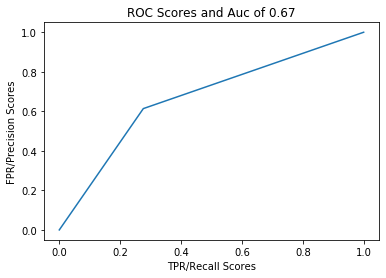

In [26]:
def graph_roc (true_r, est):
    
    fpr, tpr, thresholds = roc_curve(true_r, est)
    auc_ = auc(fpr, tpr)
    plt.plot(fpr,tpr, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(auc_, 2)))
    plt.show()
    
graph_roc(true_r, est)

In [27]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0} and {1}, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.9375411844312056 and 0.5719219676430451, respectively


### Precision and Recall values using User-Average Ratings as a Threshold

In [28]:
def user_ave_rating_threshold(df, n):
    ''' Function that averages a unique reviewerID's ratings if they have reviewed more than n books
        and returns a dictionary of threshold values and ids'''
    print(df)
    
    threshold_dict = defaultdict(list)
    
    # note--> to optimize only find the mean if it means the user_Rating_count
    
    user_ratings_ave= df.groupby('user_id')['stars'].mean()
    user_ratings_count = df.groupby('user_id')['stars'].count()
    
    for x in df['user_id'].unique():
        if user_ratings_count[x] > n:
            threshold_dict[x] = user_ratings_ave[x]
        else:
            threshold_dict[x] = 3.5
    
    return(threshold_dict)
            
        
threshold_diction = user_ave_rating_threshold(ratings_data, 8)

                    review_id                 user_id             business_id  \
0      m4AXzV9l14iFBd9DRdM82w  6X0i-oGUbh5DZdTHzFuKfg  9A1C1f0m4nQltQrOOTl-Kw   
1      A-yKlSLEQQcoHR5q2lCyHg  Yximlvn0cfb3yVDaLuXDxw  VHsNB3pdGVcRgs6C3jt6Zg   
2      asLnux3k2yqoVjcJcLuF0g  Cz8l7JQ2I_RhtK0BosH-7Q  Ah4i15g8Ow_zphzcpulTxQ   
3      YIMS3PGxfWN5iFIIcYJHEg  m7rosN4Yh__tXkWP0_myqw  9MnbQg7kfb_WgxoV0hXKSQ   
4      CWjzk0w-OZwzOmCut-6bvQ  iYwDTxhYStsIDHB514ltjA  t_yiQnxUDdPPCN2z4QyezA   
...                       ...                     ...                     ...   
35384  Fsn4u2RjnCS4kbO0OIqcCQ  51Dsi3GU4fcfxYYuW2JscQ  ly0oNXKOoSZyr0mzOsVJhg   
35385  ZnE93UGlk29kX0dfwMOGNw  ViqyzZgObMSOwWBoQbLjSg  PBmfdx-tC2D54FI3HtcKww   
35386  fGgMD8npNcGyx_Fr91m_Dg  Nl9ouJ9EqcNCX7gdPw9ZCw  dn9lwYUxmhs_mLKPu7L25Q   
35387  PJaQsm03aJVWH9xg03WN9g  Kb0rYUpYzjJqoM7cAWZBAQ  k0SB_IQ41iHessjK4hM2LA   
35388  flX4YICNgGSs2QriJ2CgRw  x4XrrBXlKABQCyv1AMHHrA  l4x5FFzfiCFrGN0S-uZbBQ   

       stars               

In [29]:
def precision_recall_at_k(predictions, threshold_dictionary, k=10):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        threshold = threshold_dictionary[uid]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [30]:
kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold_diction, k=5)

    # Precision and recall can then be averaged over all users
  
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [31]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0}.2f and {1}.2f, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.8791536774352504.2f and 0.6832817349637783.2f, respectively


In [32]:
def make_binary_tpr_fpr_user(predictions, threshold_diction):
    
    pred_df = pd.DataFrame(predictions)
    
    pred_df['threshold'] = pred_df['uid'].map(threshold_diction)
    pred_df['r_ui'].where(pred_df['r_ui']>=pred_df['threshold'], 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<pred_df['threshold'], 0, inplace=True)
    pred_df['est'].where(pred_df['est']>=pred_df['threshold'], 1, inplace=True)
    pred_df['est'].where(pred_df['est']<pred_df['threshold'], 0, inplace=True)
    
    return pred_df['r_ui'], pred_df['est']

true_r_ut, est_ut = make_binary_tpr_fpr_user(predictions, threshold_diction)

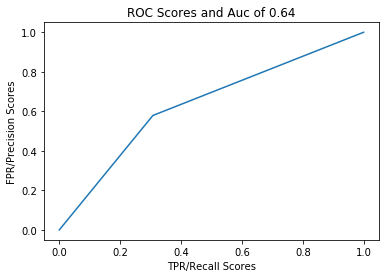

In [33]:
graph_roc(true_r_ut, est_ut)